Dans l'exploration et la production de ressources fossiles, la caractérisation des faciès rocheux est essentielle pour l'estimation des propriétés physiques de la roche, telles que la porosité et la perméabilité, ainsi que pour la détection et la simulation des réservoirs.

Je propose dans ce notebook un réseau de neurones convolutionnels pour classer les Faciès.

Ce travail est basé sur l'article https://www.researchgate.net/publication/331991539_Characterizing_Rock_Facies_Using_Machine_Learning_Algorithm_Based_on_a_Convolutional_Neural_Network_and_Data_Padding_Strategy

In [1]:
import pandas as pd
import numpy as np


import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns;



from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix



import sklearn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
torch.manual_seed(42)


In [2]:
print(f'numpy version :{ np.__version__}')
print(f'pandas version :{ pd.__version__}')
print(f'torch version :{ torch.__version__}')
print(f'altair version :{ alt.__version__}')
print(f'seaborn version :{ sns.__version__}')
print(f'scikit learn version :{sklearn.__version__}')

numpy version :1.19.2
pandas version :1.1.3
torch version :1.7.1
altair version :4.1.0
seaborn version :0.11.0
scikit learn version :0.23.2


In [3]:
df=pd.read_csv('facies_data.csv')

df=df.drop_duplicates()

In [4]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


In [5]:
df.shape

(3231, 11)

Les limites de faciès étant continues plutôt que discrètes, les propriétés mesurées pour différentes classes se chevauchent dans l'espace des fonctions et donc le tableau suivant liste les faciès, avec les faciès adjacents

In [6]:
Facies=range(1,10)
Facies_name=['SS','CSiS','FSiS','SiSh','MS','WS','D','PS','BS']
adjacent_facies = [[2], [1, 3], [2], [5], [4, 6], [5, 7], [6, 8], [6, 7, 9], [7, 8]]



df_adj=pd.DataFrame({'Facies':Facies,'Facies_Name':Facies_name,'adjacent_facies':adjacent_facies})

df_adj

,Facies,Facies_Name,adjacent_facies
0,1,SS,[2]
1,2,CSiS,"[1, 3]"
2,3,FSiS,[2]
3,4,SiSh,[5]
4,5,MS,"[4, 6]"
5,6,WS,"[5, 7]"
6,7,D,"[6, 8]"
7,8,PS,"[6, 7, 9]"
8,9,BS,"[7, 8]"


### Data

Nous avons 3231 rows et 13 variables.

Les variables caractéristiques comprennent cinq des mesures logarithmiques filaires et deux variables de contrainte géologique dérivées des connaissances géologiques.

Les sept variables sont:

1. GR: this wireline logging tools measure gamma emission
2. ILD_log10: this is resistivity measurement
3. PE: photoelectric effect log
4. DeltaPHI: Phi is a porosity index in petrophysics.
5. PNHIND: Average of neutron and density log.
6. NM_M:nonmarine-marine indicator
7. RELPOS: relative position

les différentes classes de Faciès sont:

* SS: Nonmarine sandstone
* CSiS: Nonmarine coarse siltstone
* FSiS: Nonmarine fine siltstone
* SiSH: Marine siltstone and shale
* MS: Mudstone (limestone)
* WS: Wackestone (limestone)
* D: Dolomite
* PS: Packstone-grainstone (limestone)
* BS: Phylloid-algal bafflestone (limestone)


In [7]:
df.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000,3231.000000
mean,4.420922,2875.803466,66.083567,0.642759,3.559289,13.483855,3.724681,1.498298,0.520325
std,2.503839,131.021059,30.716527,0.241872,5.229719,7.700085,0.896091,0.500074,0.286829
min,1.000000,2573.500000,13.250000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.010000
25%,2.000000,2791.000000,46.914500,0.492500,1.162500,8.343500,3.100000,1.000000,0.273000
50%,4.000000,2893.500000,65.700000,0.624591,3.500000,12.150000,3.551000,1.000000,0.526000
75%,6.000000,2980.000000,79.625000,0.812823,6.436000,16.457500,4.300000,2.000000,0.767500
max,9.000000,3122.500000,361.150000,1.480000,18.600000,84.400000,8.094000,2.000000,1.000000


In [21]:
Facies_Name={1:'SS',2:'CSiS',3:'FSiS', 4:'SiSH',5:'MS',6:'WS',7:'D',8:'PS',9:'BS'}


facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

In [9]:
#J'ajoute les noms des faciès qui sont plus explicites

df['Facies_Name']=df.Facies.map(lambda v:Facies_Name[v])

In [10]:
df.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,Facies_Name
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915,FSiS


In [11]:
df.isnull().any()

Facies         False
Formation      False
Well Name      False
Depth          False
GR             False
ILD_log10      False
DeltaPHI       False
PHIND          False
PE             False
NM_M           False
RELPOS         False
Facies_Name    False
dtype: bool

Il n'y a pas de valeurs manquantes dans nos données. Regardons à présent la distribution de nos classes.

In [12]:
alt.Chart(df).mark_bar().encode(
    x='count()',
    y='Facies_Name:N',
    color='Facies_Name:N'
        )

alt.Chart(...)

In [13]:
df.drop(['NM_M','RELPOS'],axis=1).groupby('Facies_Name').mean()


,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE
Facies_Name,,,,,,,
BS,9,3033.400621,44.877280,0.574677,0.198547,13.226944,5.295925
CSiS,2,2837.130081,74.605205,0.548171,5.309705,15.189019,3.215267
D,7,2926.974490,64.614643,0.465649,5.034133,14.080418,3.671286
FSiS,3,2875.241463,79.915083,0.547504,3.797480,20.619698,3.132340
MS,5,2957.559908,60.612788,0.820655,3.735212,9.562668,3.995184
PS,8,2890.934608,46.818412,0.747488,1.438274,9.582302,4.518087
SS,1,2749.503861,64.497761,0.371312,3.506463,14.818996,2.913313
SiSH,4,2867.282609,92.169957,0.776840,5.579728,11.152821,3.802152
WS,6,2892.073593,55.554532,0.884502,2.728424,7.442779,4.234136


In [24]:
def plot_Facies(data=df,Name='SHRIMPLIN',col_toDrop=['Formation','Well Name','RELPOS','NM_M','Facies']):
    
    '''
    inputs: data: pandas dataframe
            Name: string, name of well
            col_toDrop: col to delete
            
    output:
            altair plot
    
    '''
    
    A=df[df['Well Name']==Name].drop(col_toDrop,axis=1).melt('Depth',var_name='Category',value_name='valeur')
    char1=alt.Chart(A).mark_line().transform_filter(
    alt.datum.Category!='Facies_Name').encode(
            x=alt.X('valeur:Q', scale=alt.Scale(zero=False), axis=alt.Axis(title=None)),
            y=alt.Y('Depth:Q',scale=alt.Scale(zero=False,reverse=True)),
            color=alt.Color('Category:N',legend=None),
            column='Category:N',
            order='index:Q'
    ).properties(height=400, width=50, title='Well: '+ Name).resolve_scale(x='independent')
    
    
    
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    domain=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']
    B=df[df['Well Name']==Name]
    char2=alt.Chart(B).mark_bar().encode(
        x=alt.X('count()',axis=alt.Axis(title=None)),
        y=alt.Y('Depth:Q',scale=alt.Scale(reverse=True)),
        color=alt.Color('Facies_Name:N',scale=alt.Scale(domain=domain,range=facies_colors))
    ).properties(height=400, width=100)
    
    return alt.hconcat(char1,char2).resolve_scale(color='independent')

In [25]:
plot_Facies()

alt.HConcatChart(...)

In [289]:
corr=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M'],axis=1).corr()

corr=corr.reset_index().melt('index')
corr.columns=['var1','var2','correlation']
b=alt.Chart(corr).transform_filter(
    alt.datum.var1<alt.datum.var2).encode(
            x=alt.X('var1',axis=alt.Axis(title=None)),
            y=alt.Y('var2',axis=alt.Axis(title=None))
    ).properties(height=200,width=200)

rec=b.mark_rect().encode(
            color='correlation'
        )
text=b.mark_text().encode(
        text=alt.Text('correlation', format='.2f')
)

rec+text

alt.LayerChart(...)

In [291]:
df.columns

Index(['Facies', 'Formation', 'Well Name', 'Depth', 'GR', 'ILD_log10',
       'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS', 'Facies_Name',
       'IdxFacies'],
      dtype='object')

<Figure size 576x432 with 0 Axes>

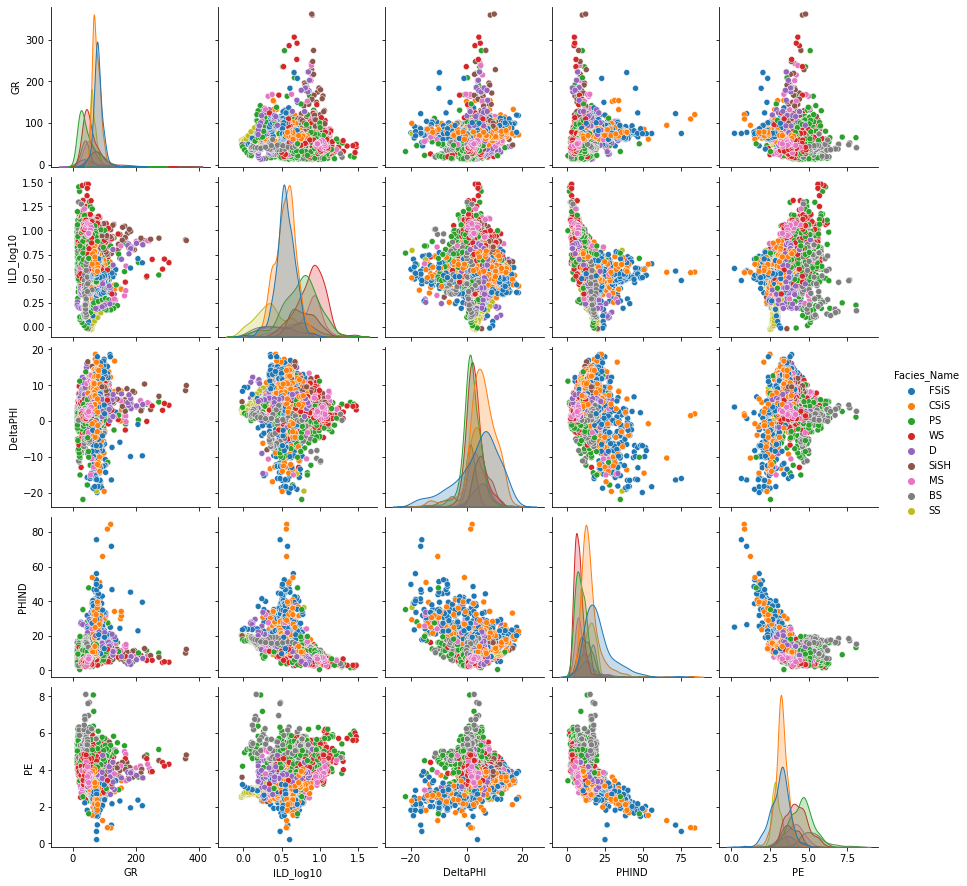

In [292]:
plt.figure(figsize=(8,6));

data=df.drop(['Depth','RELPOS','Facies','Formation','Well Name','NM_M'],axis=1);
sns.pairplot(data, hue='Facies_Name');

Nous allons essayer de visualiser à présent, en deux dimensions. 

Pour cela, la procédure est la suivante:

* normalisation StandarScaler

* PCA  en gardant 95% de la variance

* TSNE manifold (pour visualiser dans le plan des données à grande dimension). https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html



In [293]:
df_train=df.drop(['Depth','Facies','Well Name','Facies_Name','Formation'],axis=1) #Je garde les colonnes qui m'intéressent
pipe=Pipeline([('scaler',StandardScaler()), ('acp', PCA(0.95)),('manifold',TSNE())])  # pipeline (les différentes procédures)
X_manifold=pipe.fit_transform(df_train)

In [295]:
#Visualisation interactive dans le plan

df_manifold=pd.DataFrame({'X1':X_manifold[:,0],'X2':X_manifold[:,1], 'Category':df['Facies_Name']})
brush = alt.selection(type='interval')
scatter=alt.Chart(df_manifold).mark_point(filled=True).encode(
        x=alt.X('X1:Q'),
        y=alt.Y('X2:Q'),
        color='Category:N'
        ).add_selection(brush)


hist=alt.Chart(df_manifold).mark_bar().encode(
        x='count()',
        y='Category:N',
        color='Category:N'
        ).transform_filter(brush)

alt.hconcat(scatter,hist)

alt.HConcatChart(...)

Cette visualisation est interactive, choisissez un intervalle, et vous avez la distribution des classes sur cet intervalle.

On observe deux groupes (CSiS,FSiS,SS) et (WS,SiSH,PS,MS,D) qui correspondent aux non marines et marines.

Un modèle de classification distinguera bien ces deux groupes mais aura du mal à l'intérieur d'un groupe.

### Modélisation Réseau de Neurones Convolutifs

In [17]:
df['IdxFacies']=df['Facies']-1

In [18]:
def shift(seq, n=0): 
    a = n % len(seq) 
    return np.array(seq[-a:]+seq[:-a])



def padding_shift(inp):
    tampon=inp*np.ones((len(inp),len(inp)))
    
    for i in range(len(tampon)):
        tampon[i,:]=shift(list(tampon[i,:]),n=i)
    return tampon  




def preproc_data(df, features=['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'NM_M', 'RELPOS'],labels='IdxFacies'):
    
    preproc=StandardScaler().fit_transform(df[features])
    preproc=torch.tensor([padding_shift(v) for v in preproc]).unsqueeze(1)
    
    
    y=torch.tensor(df['IdxFacies'].values).long()
    
    
    return TensorDataset(preproc,y)
    
    

In [100]:
df_val=df[df['Well Name']=='SHRIMPLIN']

df_train,df_test=train_test_split(df[df['Well Name']!='SHANKLE'],test_size=0.1,stratify=df[df['Well Name']!='SHANKLE']['IdxFacies'])

In [101]:
dataset_train=preproc_data(df_train)

dataset_test=preproc_data(df_test)

dataset_val=preproc_data(df_val)


In [102]:
batch_size=14
train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle=True, num_workers=0)

test_loader = DataLoader(dataset = dataset_test, batch_size = 1, shuffle=True, num_workers=0)

val_loader = DataLoader(dataset = dataset_val, batch_size = 1, shuffle=True, num_workers=0)

In [120]:
class ConvFacies(nn.Module):
    def __init__(self):
        super().__init__()
        
        #shape=(w-f+2p/s)+1
        
        self.network = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),  #shape: 4*4*8
            
            nn.Conv2d(8,16,kernel_size=3), #shape=2*2*16
            nn.ReLU(),
            

            nn.Flatten(),
            nn.Linear(in_features=2*2*16, out_features=16),
            nn.ReLU(),
            nn.Linear(16, 9))
            
    def forward(self, xb):
        return self.network(xb)

In [121]:
train_count=df_train.shape[0]
test_count=df_test.shape[0]





In [122]:
path='model_state_dict.pt'
best_accuracy=0



accuracy_stats = {
    'train': [],
    "test": []
}


loss_stats = {
    'train': [],
    "test": []
}




model=ConvFacies().double()
lr=0.001 #learning rate
epochs=200
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr)

for epoch in range(epochs):
    
    train_epoch_loss=0
    train_epoch_accuracy=0
    
    
    for i,(inp,label) in enumerate(train_loader):
        output=model(inp)
        loss=criterion(output,label)
        
        optimizer.zero_grad() # on remet à zéro les gradients
        loss.backward() #Calcule le gradient
        optimizer.step() #mets à jour les poids et biais
        
        
        train_epoch_loss+=loss.item()
        _, predicted = torch.max(output.data, 1)
        train_epoch_accuracy+=(predicted == label).sum().item()
        
    train_epoch_loss/=train_count 
    train_epoch_accuracy/=train_count
    loss_stats['train'].append(train_epoch_loss)
    accuracy_stats['train'].append(train_epoch_accuracy)   
    

    with torch.no_grad():
        
        model.eval()
            
        test_epoch_loss=0
        test_epoch_accuracy=0
            
        for i,(inp,label) in enumerate(test_loader):
                
            output=model(inp)
            test_loss=criterion(output,label)

            test_epoch_loss+=test_loss.item()
            _, predicted = torch.max(output.data, 1)
            test_epoch_accuracy+=(predicted == label).sum().item()

        test_epoch_loss/=test_count        
        test_epoch_accuracy/=test_count 
        loss_stats['test'].append(test_epoch_loss)
        accuracy_stats['test'].append(test_epoch_accuracy)

         
        

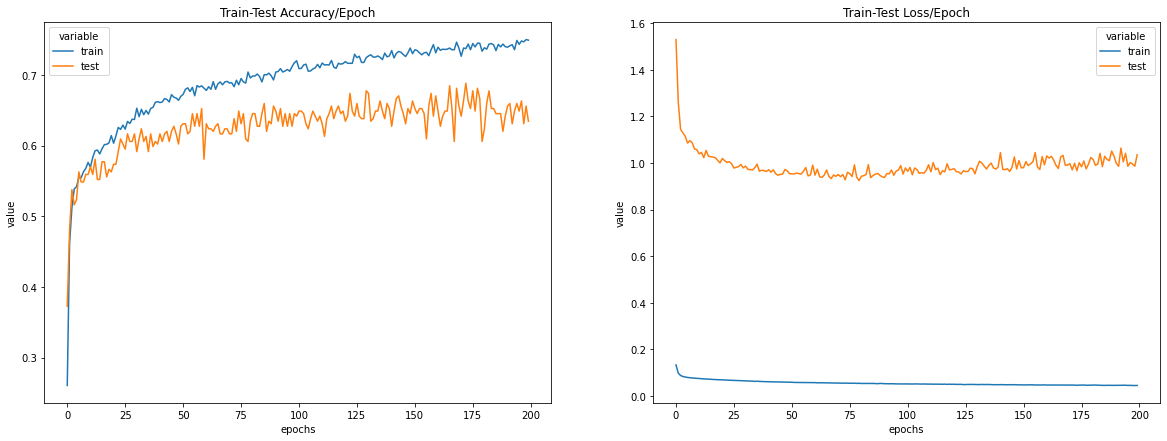

In [123]:

# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Test Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Test Loss/Epoch');


In [118]:
def get_accuracy(data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in data_loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return (100 * correct / total)

In [124]:
print(f'accuracy train: { get_accuracy(train_loader):.1f}%')

print(f'accuracy test: { get_accuracy(test_loader):.1f}%')

print(f'accuracy val: { get_accuracy(val_loader):.1f}%')

accuracy train: 76.0%
accuracy test: 63.4%
accuracy val: 58.5%


In [125]:
prediction=[]
labels = []
with torch.no_grad():
    for data in val_loader:
        inp, label = data
        outputs = model(inp)
        _, predicted = torch.max(outputs.data, 1)
        labels.append(label)
        prediction.append(predicted)
        
prediction = [a.squeeze().tolist() for a in prediction]        
labels = [a.squeeze().tolist() for a in labels]        

In [137]:
target_name=['SS','CSiS','FSiS', 'SiSH','MS','WS','D','PS','BS']
print(classification_report(labels, prediction,target_names=target_name))

              precision    recall  f1-score   support

          SS       0.00      0.00      0.00         0
        CSiS       0.87      0.57      0.69       118
        FSiS       0.71      0.89      0.79       123
        SiSH       0.41      0.67      0.51        18
          MS       0.00      0.00      0.00        63
          WS       0.40      0.68      0.51        63
           D       0.00      0.00      0.00         5
          PS       0.53      0.63      0.58        68
          BS       0.00      0.00      0.00        12

    accuracy                           0.59       470
   macro avg       0.33      0.38      0.34       470
weighted avg       0.55      0.59      0.55       470



In [154]:
idx2class={0:'SS',1:'CSiS',2:'FSiS', 3:'SiSH',4:'MS',5:'WS',6:'D',7:'PS',8:'BS'}
idx2Facies={v-1:v for v in range(1,10)}


df_confusion=pd.DataFrame(confusion_matrix(labels,prediction)).rename(columns=idx2Facies,index=idx2Facies)


In [157]:
conf=df_confusion.reset_index().melt('index')
conf.columns=['var1','var2','number']
b=alt.Chart(conf).encode(
            x=alt.X('var1:N',axis=alt.Axis(title='Prédiction')),
            y=alt.Y('var2:N',axis=alt.Axis(title='True Value'))
    )
#.properties(height=400,width=400)

rec=b.mark_rect().encode(
            color='number'
        )
text=b.mark_text().encode(
        text=alt.Text('number')
)

rec+text

alt.LayerChart(...)

In [266]:
conf=confusion_matrix(labels,prediction)
adjacent_facies = [[1], [0, 2], [1], [4], [3, 5], [4, 6, 7], [5, 7], [5, 6, 8], [6, 7]]


def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0
    for i in np.arange(0, nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))


print(accuracy_adjacent(conf, adjacent_facies))

0.948936170212766
